<a href="https://colab.research.google.com/github/Alokkumar321/Basic-Programs-in-CPP/blob/main/celebal_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aalokk","key":"e86c668ca01260d0634f30487dfd35fd"}'}

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


In [2]:
!kaggle competitions download -c celebal-ana-verse-j


celebal-ana-verse-j.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip celebal-ana-verse-j.zip


Archive:  celebal-ana-verse-j.zip
replace sample_submission.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
import pandas as pd
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
train.head()


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


In [6]:
print(train.isnull().sum())
print(train['target'].value_counts(normalize=True))


Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64
target
0    0.991437
1    0.008563
Name: proportion, dtype: float64


In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
for df in [train, test]:
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
train.drop(columns=['Date'], inplace=True)
test.drop(columns=['Date'], inplace=True)


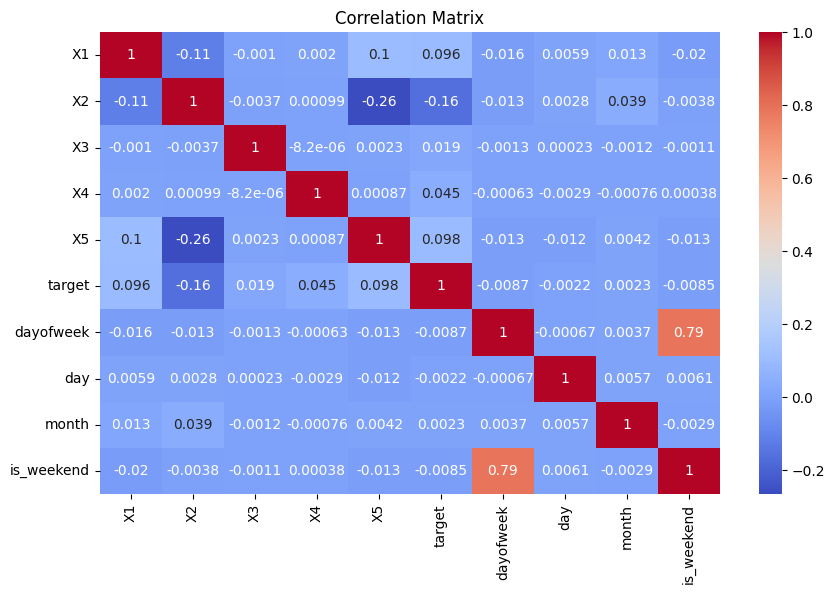

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [9]:
print(train.columns)


Index(['X1', 'X2', 'X3', 'X4', 'X5', 'target', 'dayofweek', 'day', 'month',
       'is_weekend'],
      dtype='object')


In [10]:
print(train.dtypes)


X1            float64
X2            float64
X3            float64
X4            float64
X5            float64
target         object
dayofweek       int32
day             int32
month           int32
is_weekend      int64
dtype: object


In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

X = train.drop(columns=['target'])
X = X.select_dtypes(include='number')

y = train['target'].astype(int)

models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_models(models, X, y):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv)
        results[name] = scores.mean()
        print(f'{name}: Mean F1 Score = {scores.mean():.4f}')
    return results

results = evaluate_models(models, X, y)


Logistic Regression: Mean F1 Score = 0.1318
K-Nearest Neighbors: Mean F1 Score = 0.5142
Decision Tree: Mean F1 Score = 0.5115


In [12]:
!pip install xgboost lightgbm catboost -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.8 MB/s eta 0:00:00


In [12]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

advanced_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

def evaluate_models(models, X, y):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        scores = cross_val_score(pipeline, X, y, scoring='f1', cv=5)
        results[name] = scores.mean()
        print(f'{name}: Mean F1 Score = {scores.mean():.4f}')
    return results

results_adv = evaluate_models(advanced_models, X, y)


Random Forest: Mean F1 Score = 0.2879


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost: Mean F1 Score = 0.2725


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11231, number of negative: 1300308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008563 -> initscore=-4.751679
[LightGBM] [Info] Start training from score -4.751679


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11230, number of negative: 1300309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008562 -> initscore=-4.751768
[LightGBM] [Info] Start training from score -4.751768


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11230, number of negative: 1300309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008562 -> initscore=-4.751768
[LightGBM] [Info] Start training from score -4.751768


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11230, number of negative: 1300309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008562 -> initscore=-4.751768
[LightGBM] [Info] Start training from score -4.751768


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11231, number of negative: 1300309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1311540, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008563 -> initscore=-4.751679
[LightGBM] [Info] Start training from score -4.751679


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM: Mean F1 Score = 0.3629


In [16]:

balanced_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}


In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print("After under-sampling:")
print(pd.Series(y_res).value_counts())

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_res, y_res)

print("\nAfter under-sampling + SMOTE:")
print(pd.Series(y_bal).value_counts())


After under-sampling:
target
0    140380
1     14038
Name: count, dtype: int64

After under-sampling + SMOTE:
target
0    140380
1    140380
Name: count, dtype: int64


In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def evaluate_after_smote(models, X_bal, y_bal):
    print("Evaluating models after SMOTE...\n")
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        scores = cross_val_score(model, X_bal, y_bal, cv=5, scoring=make_scorer(f1_score))
        results[name] = np.mean(scores)
        print(f"{name}: Mean F1 Score = {results[name]:.4f}")
    return results


In [20]:
results_balanced = evaluate_after_smote(balanced_models, X_bal, y_bal)


Evaluating models after SMOTE...

Training Random Forest...
Random Forest: Mean F1 Score = 0.9841
Training XGBoost...
XGBoost: Mean F1 Score = 0.9755
Training LightGBM...
[LightGBM] [Info] Number of positive: 112304, number of negative: 112304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 224608, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 112304, number of negative: 112304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

In [22]:
df.columns


Index(['ID', 'X1', 'X2', 'X3', 'X4', 'X5', 'dayofweek', 'day', 'month',
       'is_weekend'],
      dtype='object')

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Train on training data
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Predict on test set
y_pred = final_model.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[27454   622]
 [  301 27775]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     28076
           1       0.98      0.99      0.98     28076

    accuracy                           0.98     56152
   macro avg       0.98      0.98      0.98     56152
weighted avg       0.98      0.98      0.98     56152



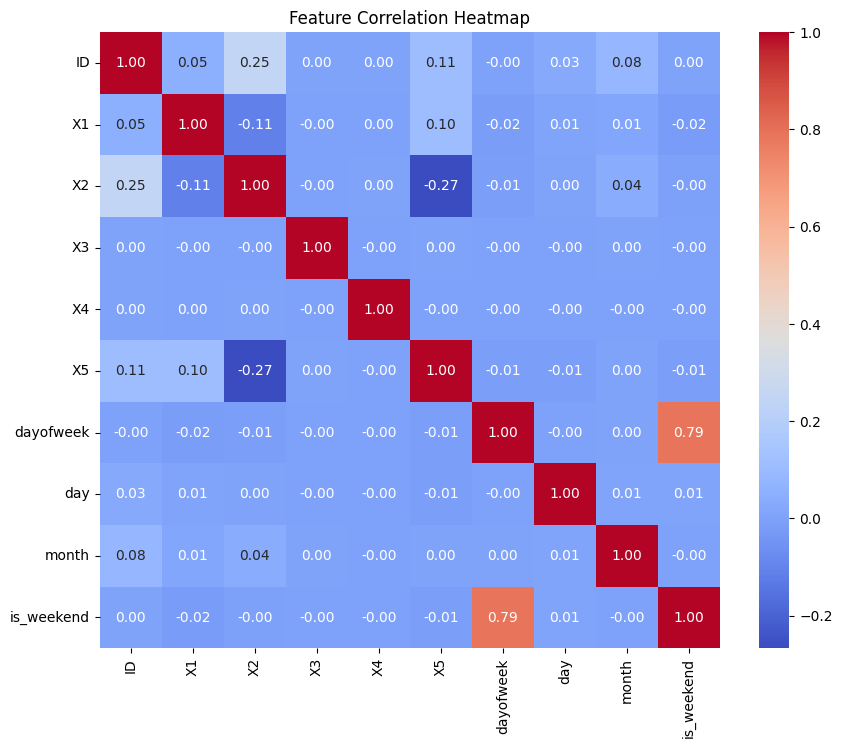

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


### Cross-Validation for Robust Evaluation

We used 5-fold cross-validation (`cross_val_score`) during model evaluation. This helped avoid overfitting and provided a more reliable estimate of model performance by averaging results over different splits of the training data.


### Cross-Validation for Robust Evaluation

We used 5-fold cross-validation (`cross_val_score`) during model evaluation. This helped avoid overfitting and provided a more reliable estimate of model performance by averaging results over different splits of the training data.


### SMOTE Strategy to Address Imbalance

To handle class imbalance, we first under-sampled the majority class and then applied SMOTE (Synthetic Minority Oversampling Technique) to the training set. This was done after splitting the data to avoid data leakage, ensuring that the test set remains unbiased and representative of real-world data.
